# How to think about treating heterogeneous initial populations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sys
import pickle
from pyDOE import *
from scipy.stats.distributions import norm

In [3]:
u_N = .02
u_SCM = .005
u_TM = 0.32
u_CM = 0.35
u_EM = 0.30
u_EMRA = 0.005
std = 0.1
u_T = [u_N, 0, u_SCM,0, u_TM,0, u_CM, 0,u_EM,0,u_EMRA,0]

In [26]:
sims = 10000
design = lhs(6, samples=sims)
means = u_T
stdvs = [std,0]*6
for i in range(6):
    design[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(design[:, i])

design[~(abs(design)>0)] = 0
sim_init = abs(design)

/home/qiuwu/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


In [8]:
# Set plotting parameters
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

## Define Model

In [31]:
#Define the model
def model(z,t):
    L_n = z[0]
    L_scm = z[2]
    L_tm = z[4]
    L_cm = z[6] 
    L_em = z[8]
    L_emra = z[10]
    
    A_n = z[1]
    A_scm = z[3]
    A_tm = z[5]
    A_cm = z[7]
    A_em = z[9]
    A_emra = z[11]
    
    
    #for drug dosings
    dL_ndt = (p_n - d_n)*L_n - a*L_n + w*A_n
    dA_ndt = a*L_n - d_ALL*A_n - w*A_n
    
    dL_scmdt = (p_scm - d_scm)*L_scm - a*L_scm + w*A_scm
    dA_scmdt = a*L_scm - d_ALL*A_scm - w*A_scm
    
    dL_tmdt = (p_tm - d_tm)*L_tm - a*L_tm + w*A_tm
    dA_tmdt = a*L_tm - d_ALL*A_tm - w*A_tm
    
    dL_cmdt = (p_cm - d_cm)*L_cm - a*L_cm + w*A_cm
    dA_cmdt = a*L_cm - d_ALL*A_cm - w*A_cm
    
    dL_emdt = (p_em - d_em)*L_em - a*L_em + w*A_em
    dA_emdt = a*L_em - d_ALL*A_em - w*A_em
    
    dL_emradt = (p_emra - d_emra)*L_emra - a*L_emra + w*A_emra
    dA_emradt = a*L_emra - d_ALL*A_emra - w*A_emra
    
    
    dzdt = [dL_ndt,dA_ndt,
            dL_scmdt,dA_scmdt,
            dL_tmdt,dA_tmdt,
            dL_cmdt,dA_cmdt,
            dL_emdt,dA_emdt,
            dL_emradt,dA_emradt
            ]
    return dzdt

In [12]:
LRA_tmp = np.linspace(0,100,101)
d_tmp = np.linspace(0,1,101)
parameter_arr_1 = LRA_tmp
parameter_arr_2 = d_tmp
parameter_letter = 'LRA'


#number of time points
tn = 2000

#store solutions
L_n = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
L_scm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
L_tm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
L_cm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
L_em = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
L_emra = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])

A_n = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
A_scm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
A_tm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
A_cm = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
A_em = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
A_emra = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])
Total = np.zeros([parameter_arr_1.shape[0],parameter_arr_2.shape[0],tn])





for i,parameter_1 in enumerate(parameter_arr_1):
    for j,parameter_2 in enumerate(parameter_arr_2):
    #initial conditions, there are three
        w = 1/20 # In Ke's 2015 paper, it looks like a reasonable assumption is 20-50 days because thats where copies of vRNA start dropping
        d = 1
        LRA = 1
        d_ALL = 0.003

        LRA = parameter_1
        d = parameter_2

        #set parameters

        p_cm = 0.00075 * d
        p_tm = 0.0006 * d
        p_em = 0.0003 * d
        p_n = 0.000099 * d
        p_scm = 0.00001 * d
        p_emra = 0.00005 * d


        corr_fact = -np.log(1/2)
        d_n = corr_fact * (1/1500)
        d_scm = corr_fact * (1/150)
        d_tm = corr_fact * (1/100)
        d_cm = corr_fact * (1/120)
        d_em = corr_fact * (1/90)
        d_emra = corr_fact * (1/250)
        n = 0.00017
        a = n * LRA


        z0 = np.zeros(12)
        ctr=0
        for g in range(6):
            z0[ctr] = u_T[g]*10**6
            ctr+=2

        #time points
        b = 2000
        tn = 60001
        t = np.linspace(0,tn-1, b)


        #record intial

        L_n[i][j][0] = z0[0]
        L_scm[i][j][0] = z0[2]
        L_tm[i][j][0] = z0[4]
        L_cm[i][j][0] = z0[6] 
        L_em[i][j][0] = z0[8]
        L_emra[i][j][0] =z0[10]

        A_n[i][j][0] = z0[1]
        A_scm[i][j][0] = z0[3]
        A_tm[i][j][0] = z0[5]
        A_cm[i][j][0] = z0[7]
        A_em[i][j][0] = z0[9]
        A_emra[i][j][0] = z0[11]

        Total[i][j][0] = np.sum(z0)

        #Solve the ODE
        for k in range(1,b):
            tspan = [t[k-1],t[k]]
            # solve for next step
            z = odeint(model,z0,tspan)
            # store solution for plotting

            L_n[i][j][k] = z[1][0]
            L_scm[i][j][k] = z[1][2]
            L_tm[i][j][k] = z[1][4]
            L_cm[i][j][k] = z[1][6] 
            L_em[i][j][k] = z[1][8]
            L_emra[i][j][k] = z[1][10]

            A_n[i][j][k] = z[1][1]
            A_scm[i][j][k] = z[1][3]
            A_tm[i][j][k] = z[1][5]
            A_cm[i][j][k] = z[1][7]
            A_em[i][j][k] = z[1][9]
            A_emra[i][j][k] = z[1][11]





            Total[i][j][k] =np.sum(z[1])
            z0 = z[1] 
        sys.stdout.write('\r {},{}'.format(i,j) )

t = t/365
pop_dict = {}
pop_dict['latent'] = [L_n, L_scm, L_tm, L_cm, L_em, L_emra]
pop_dict['active'] = [A_n, A_scm, A_tm, A_cm, A_em, A_emra]
pop_dict['times'] = t
pop_dict['total'] = Total
pop_dict['cell_type'] = ['T_n', 'T_scm', 'T_tm', 'T_cm','T_em', 'T_emra']



 100,100

In [9]:
parameter_arr_1 = pop_dict['LRA']
parameter_arr_2 = pop_dict['d']

In [14]:
#pickle.dump(pop_dict,open('190430_LRA_d_sensitivity.p', 'wb'))

In [4]:
pop_dict = pickle.load(open('190430_LRA_d_sensitivity.p','rb'))

In [5]:
b = 2000
tn = 60001
t = np.linspace(0,tn-1, b)/365
hy_heatmap = np.zeros([101,101])
for i in range(101):
    for j in range(101):
        a= np.where(pop_dict['total'][i,j] < 10**2)[0]
        if len(a) == 0:
            hy_heatmap[i,j] = 0
        else:
            hy_heatmap[i,j] = t[a[0]]

/home/qiuwu/anaconda3/envs/scanpy_env/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


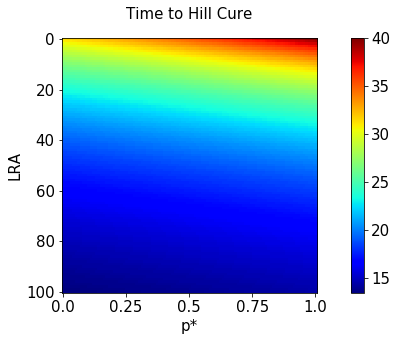

In [9]:
plt.figure(figsize = (10,5))
plt.imshow(hy_heatmap, cmap = 'jet')
plt.colorbar()
plt.ylabel('LRA')
plt.yticks(np.arange(0, 120, step=20))
plt.xlabel('p*')
plt.xticks(np.arange(0,125, step = 25), np.arange(0,1.25, step = .25))
ttl = plt.title('Time to Hill Cure', fontsize = 15)
ttl.set_position([0.5, 1.05])
plt.tight_layout()

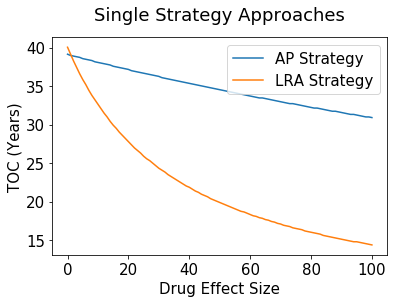

In [11]:
plt.plot(100 - np.linspace(0,100,101), hy_heatmap[1,:], label = 'AP Strategy')
plt.plot(np.linspace(0,100,101), hy_heatmap[:,100], label = 'LRA Strategy')
plt.title('Single Strategy Approaches', y = 1.05)
plt.xlabel('Drug Effect Size')
plt.ylabel('TOC (Years)')
plt.legend(loc = 'upper right')

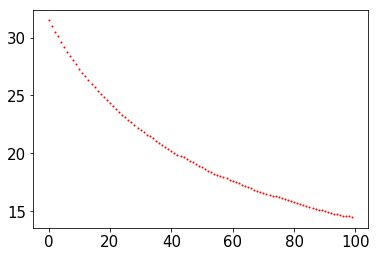

In [85]:
for i in range(100):
    plt.scatter(i, hy_heatmap[i,i], s = 1, c = 'r')

In [86]:
pop_dict['total'].shape

(101, 101, 2000)

In [87]:
LRA_tmp = pop_dict['total'][:,100, :]
AP_tmp = pop_dict['total'][1,:, :]

In [88]:
tmp = LRA_tmp.reshape(101,100,20)
ht = np.mean(tmp, axis = 2)

([<matplotlib.axis.YTick at 0x7f17a20ef748>,
 <a list of 3 Text yticklabel objects>)

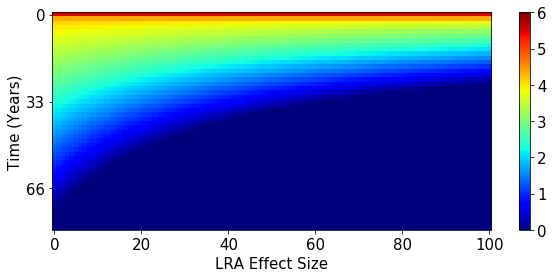

In [113]:
plt.figure(figsize = (10,4))
plt.imshow(np.log10(ht).T[:50,:], clim = ([0,6]), cmap = 'jet')
plt.xlabel('LRA Effect Size')
plt.ylabel('Time (Years)')
plt.colorbar()
plt.yticks(np.arange(0,50, step = 20),(np.round(t.reshape(100,20).T[0]).reshape(5,20).T[0]).astype(int))


([<matplotlib.axis.YTick at 0x7f17a18299e8>,
 <a list of 3 Text yticklabel objects>)

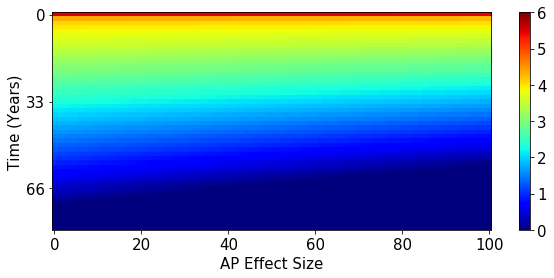

In [120]:
tmp = AP_tmp.reshape(101,100,20)
at = np.mean(tmp, axis = 2)

plt.figure(figsize = (10,4))
plt.imshow(np.flip(np.log10(at).T[:50,:],1), clim = ([0,6]), cmap = 'jet')
plt.xlabel('AP Effect Size')
plt.ylabel('Time (Years)')
plt.colorbar()
plt.yticks(np.arange(0,50, step = 20),(np.round(t.reshape(100,20).T[0]).reshape(5,20).T[0]).astype(int))


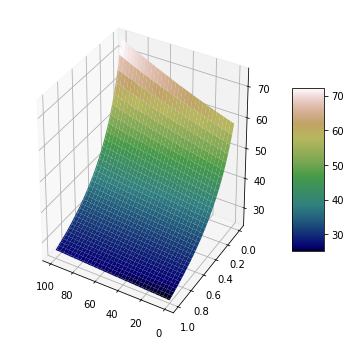

In [10]:
from mpl_toolkits.mplot3d import axes3d
#if using a Jupyter notebook, include:
%matplotlib inline

x = parameter_arr_1
y = parameter_arr_2
X,Y = np.meshgrid(x,y)
Z = hy_heatmap


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
mycmap = plt.get_cmap('gist_earth')

n_wf = ax.plot_surface(X, Y, Z, cmap = mycmap)
fig.colorbar(n_wf, ax = ax, shrink = .5, aspect = 5 )


ax.view_init(30, 120)


